In [1]:
# Core libs
import pandas as pd
import numpy as np

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "browser"

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

#scipy kit
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.spatial.distance import pdist

In [5]:
log_data = pd.read_pickle('log_data_pak_full')

pca = PCA(n_components=3)
df_st =  StandardScaler().fit_transform(log_data)
pca_out = pca.fit(df_st)
pca_transformer = pca.transform
components = pca.fit_transform(df_st)

linkage_data = np.load('hirarchy_model.npy')

In [7]:
#clusters = fcluster(linkage_data, 1.1547005383792515)
clusters = DBSCAN(eps = 0.3).fit(components)
clusters = [str(key) for key in clusters.labels_]

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=log_data['Área Construcción'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.update_traces(marker_size = 1)

fig.show()

In [4]:
pca_2 = PCA(n_components=2)
df_st =  StandardScaler().fit_transform(components)
pca_out_2 = pca_2.fit(df_st)
components_2 = pca_2.fit_transform(df_st)

In [12]:
#clusters = KMeans(n_clusters=13).fit(components_2)
#clusters = fcluster(linkage_data, 1.1547005383792515)
#clusters = DBSCAN().fit()

clusters = DBSCAN(eps = 0.6, min_samples=100).fit(components)
clusters = [str(key) for key in clusters.labels_]

total_var = pca_2.explained_variance_ratio_.sum() * 100

fig = px.scatter(
    #components_2, x=0, y=1, color=log_data['Valor comercial (USD)'],
    components_2, x=0, y=1, color=clusters,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.update_traces(marker_size = 1)

fig.show()

In [5]:
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model

2022-10-22 06:40:52.462207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 06:40:52.620863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 06:40:53.208786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-22 06:40:53.208845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [6]:
log_data['Valor comercial (USD)'].max()

7.553183953795418

In [7]:
components

array([[-0.25049918, -0.65919807,  0.58870169],
       [ 0.08921403, -0.45394378,  0.6871101 ],
       [-0.64231704, -0.84000948,  0.40804177],
       ...,
       [-0.98868778,  0.75942328,  0.02638232],
       [-0.10360631, -0.61426205,  0.71234044],
       [-1.73342472,  2.49666437, -0.67305099]])

In [8]:
X_train = components.copy()
Y_train = log_data['Valor comercial (USD)'].to_numpy()

In [9]:
Xin = Input(shape=(3,),name='transformed_input')
X = Dense(15, activation='relu', name='hidden_1')(Xin)
X = Dense(10, activation='relu', name='hidden_2')(X)
X = Dense(5, activation='relu', name='hidden_3')(X)

Yout = Dense(1, activation='softplus', name='predictor')(X)


2022-10-22 06:41:01.424998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 06:41:01.485811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 06:41:01.486011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 06:41:01.486411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
S4D_gumbo = Model(inputs = Xin, outputs = [Yout], name = 'S4DGumbo')

In [33]:
def mape_accuracy(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract(y_true,y_pred),y_true)) < 0.1, tf.int16), axis=1)
    total = y_true.shape[1]

    return correct/total

In [34]:
epochs     = 5         # número de epocas
batch_size = 20        # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

S4D_gumbo.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = tf.keras.losses.mean_absolute_percentage_error,
                  metrics   = [mape_accuracy])



In [35]:
history = S4D_gumbo.fit(x                = X_train,
                        y                = Y_train,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

Epoch 1/5
1705/1705 [==============================] - 7s 4ms/step - loss: 54.8418 - mape_accuracy: 0.1197 - val_loss: 13.0996 - val_mape_accuracy: 0.5781
Epoch 2/5
1705/1705 [==============================] - 6s 4ms/step - loss: 11.0332 - mape_accuracy: 0.6391 - val_loss: 9.3646 - val_mape_accuracy: 0.6715
Epoch 3/5
1705/1705 [==============================] - 6s 4ms/step - loss: 7.8946 - mape_accuracy: 0.7238 - val_loss: 6.4852 - val_mape_accuracy: 0.8020
Epoch 4/5
1705/1705 [==============================] - 6s 4ms/step - loss: 5.1648 - mape_accuracy: 0.8853 - val_loss: 4.0941 - val_mape_accuracy: 0.9404
Epoch 5/5
1705/1705 [==============================] - 6s 3ms/step - loss: 3.5996 - mape_accuracy: 0.9517 - val_loss: 3.3015 - val_mape_accuracy: 0.9579


In [36]:
print(history.history.keys())

dict_keys(['loss', 'mape_accuracy', 'val_loss', 'val_mape_accuracy'])


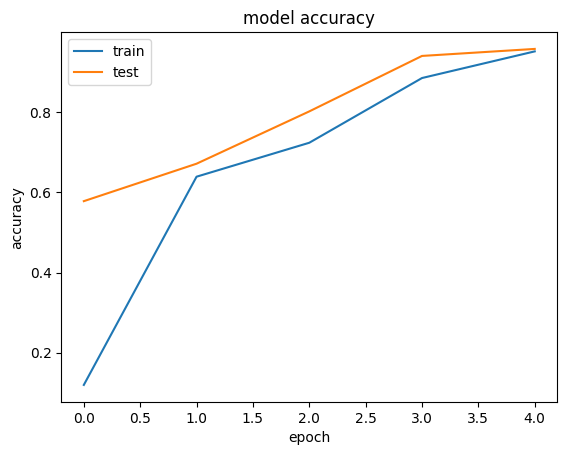

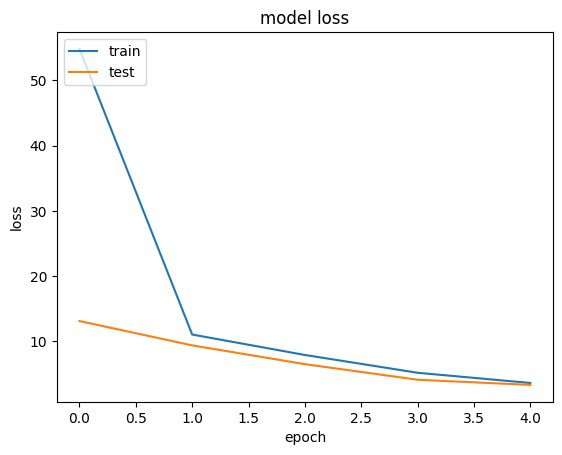

In [39]:
plt.plot(history.history['mape_accuracy'])
plt.plot(history.history['val_mape_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()